In [93]:
import numpy as np
import sys
#!{sys.executable} -m pip install do_mpc
import do_mpc
# !{sys.executable} -mpip install slycot  
# !{sys.executable} -mpip install control
import control
# import slycot
import matplotlib.pyplot as plt
from math import inf, pi, sin
# !{sys.executable} -m pip install --upgrade scipy
from scipy.integrate import odeint

# Semestralni prace

## Parametry systemu (inverse pendulum)

In [39]:
M = .5
m = 0.2
b = 0.1
I = 0.006
g = 9.8
l = 0.3

### State space Vector:

\begin{bmatrix}
       x \\
       \dot{x} \\
       \theta \\
       \dot{\theta}
 \end{bmatrix}

In [40]:
p = I*(M+m)+M*m*l**2

In [41]:
A = [[0,      1,              0,           0],
     [0, -(I+m*l**2)*b/p,  (m**2*g*l**2)/p,   0],
     [0,      0,              0,           1],
     [0, -(m*l*b)/p,       m*g*l*(M+m)/p,  0]]

B = [[     0],
     [(I+m*l**2)/p],
     [     0],
     [   m*l/p]]

C = [[1, 0, 0, 0],
     [0, 0, 1, 0]]

D = [[0],
     [0]]


print(A)
print(B)
print(C)
print(D)

[[0, 1, 0, 0], [0, -0.18181818181818182, 2.6727272727272737, 0], [0, 0, 0, 1], [0, -0.45454545454545453, 31.181818181818183, 0]]
[[0], [1.8181818181818181], [0], [4.545454545454545]]
[[1, 0, 0, 0], [0, 0, 1, 0]]
[[0], [0]]


In [42]:
sys = control.StateSpace(A, B, C, D)

c:\users\kpass\appdata\local\programs\python\python37\lib\site-packages\control\timeresp.py:1037: RuntimeWarning: overflow encountered in matmul
  + Bd0 @ U[:, i-1] + Bd1 @ U[:, i])
c:\users\kpass\appdata\local\programs\python\python37\lib\site-packages\control\timeresp.py:1037: RuntimeWarning: invalid value encountered in matmul
  + Bd0 @ U[:, i-1] + Bd1 @ U[:, i])
c:\users\kpass\appdata\local\programs\python\python37\lib\site-packages\control\timeresp.py:1038: RuntimeWarning: invalid value encountered in matmul
  yout = C @ xout + D @ U


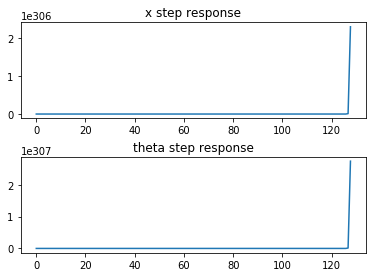

In [43]:
response = control.step_response(sys)

fig, axs = plt.subplots(2)
axs[0].plot(response.time, response.outputs[0][0])
axs[0].set_title('x step response')
axs[1].plot(response.time, response.outputs[1][0])
axs[1].set_title('theta step response')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


In [44]:
w, v = np.linalg.eig(A)

In [45]:
print(w) # eigenvalues (vlastni cisla), jedno je kladne -> system je nestabilni

[ 0.         -0.14283164 -5.60409413  5.56510758]


## Controllability and observability

In [46]:
# Making controllability gram matrix:

R = control.ctrb(A, B) # [B, A*B, A^2*B, A^3*B]
print(R)
print(np.linalg.matrix_rank(R))

[[  0.           1.81818182  -0.33057851  12.20886551]
 [  1.81818182  -0.33057851  12.20886551  -4.42865924]
 [  0.           4.54545455  -0.82644628 141.88580015]
 [  4.54545455  -0.82644628 141.88580015 -31.319582  ]]
4


## State feedback controller:

In [47]:
# Place new poles, so the system would be stable: 

des_eig = [-1.1, -1.2, -1.3, -1.4]
K = control.place(A, B, des_eig)

print(K)

[[-0.05393143 -0.27397959  8.93857257  1.16959184]]


In [48]:
# New eigenvalues of the close loop system with state controller, so the system is now stable:

w_n, v_n = np.linalg.eig(A-B*K)
print(w_n)

[-1.4 -1.3 -1.2 -1.1]


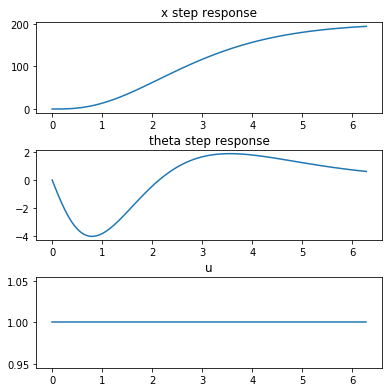

In [49]:
# trying out step on system with state controller: 

state_ctrl_fdbk_sys = control.StateSpace(A-B*K, -K.transpose(), C, D)

response_state_ctrl = control.step_response(state_ctrl_fdbk_sys)

fig, axs = plt.subplots(3)
axs[0].plot(response_state_ctrl.time, response_state_ctrl.outputs[0][0])
axs[0].set_title('x step response')
axs[1].plot(response_state_ctrl.time, response_state_ctrl.outputs[1][0])
axs[1].set_title('theta step response')
axs[2].plot(response_state_ctrl.time, response_state_ctrl.inputs[0][0])
axs[2].set_title('u')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)

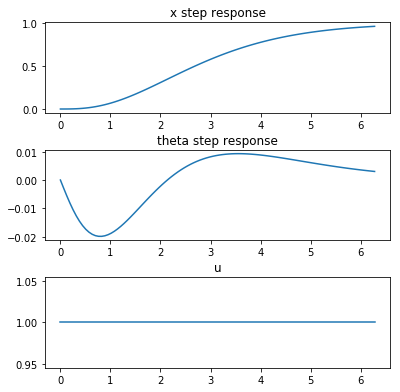

In [50]:
# rescaling:

k_ctrl_fdbk = control.dcgain(state_ctrl_fdbk_sys)
kr = [1/k_ctrl_fdbk[0][0], 1, 1/k_ctrl_fdbk[1][0], 1]

state_ctrl_fdbk_sys = control.StateSpace(A-B*K, -K.transpose(), C, D)

state_ctrl_fdbk_sys *= kr

response_state_ctrl = control.step_response(state_ctrl_fdbk_sys)

fig, axs = plt.subplots(3)
axs[0].plot(response_state_ctrl.time, response_state_ctrl.outputs[0][0])
axs[0].set_title('x step response')
axs[1].plot(response_state_ctrl.time, response_state_ctrl.outputs[1][0])
axs[1].set_title('theta step response')
axs[2].plot(response_state_ctrl.time, response_state_ctrl.inputs[0][0])
axs[2].set_title('u')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)

### Mathematical equations for inverted pendulum:



1) $(I + m.l^2) \cdot \ddot{\theta} - m.g.l.\theta = m.l.\ddot{x}$

2) $(M + m) \cdot \ddot{x} + b.\dot{x} - m.l.\ddot{\theta} = F$

          _|  |_
          \    /
           \  /
            \/
                    
1) $\ddot{\theta} = \frac{m.l}{(I+m.l^2)} \cdot \ddot{x} + \frac{m.g.l}{I+m.l^2} \cdot \dot{\theta}$

2) $ \ddot{x} = \frac{-b}{(M+m)} \cdot \dot{x} + \frac{m.l}{M+m} \cdot \ddot{\theta} + F$

          _|  |_
          \    /
           \  /
            \/
            
  $q = (I+m.l^2) \cdot (M+m) - (m.l)^2$
  
1) $\ddot{\theta} = \frac{-b.m.l}{q} \cdot \dot{x} + \frac{m.l.(M+m)}{q} \cdot F + \frac{m.g.l.(I+m.l^2)}{q} \cdot \dot{\theta}$

2) $ \ddot{x} = \frac{-b.(I+ml^2)}{q} \cdot \dot{x} + \frac{g.(ml)^2}{q} \cdot \dot{\theta} + \frac{(M+m)(I+ml^2)}{q} \cdot F$


## Simulating non-linear model of inverted pendulum:

In [51]:
# Simulating non-linear system

def inverted_pend_update(t, x, u, params):
    
    M = params.get('m', .5)     # mass of the cart
    m = params.get('M', 0.2)   # mass of the pendulum
    b = params.get('c', 0.1)   # coefficient of the friction
    I = params.get('I', 0.006) # mass moment of inertia of the pendulum
    g = params.get('g', 9.8)   # acceleration of gravity
    l = params.get('l', 0.3)   # length to pendulum center of mass
    
    x_ = x[0]
    dot_x = x[1]
    theta = x[2]
    dot_theta = x[3]
    F = u
    
    q = (I + m*l**2)*(M + m) - (m*l**2)
    
    ddot_x = ((-b*(I+m*l**2))/q)*dot_x + ((g*(m*l)**2)/q)*dot_theta + (((M+m)*(I+m*l**2))/q)*F
    ddot_theta = ((-b*m*l)/q)*dot_x + ((m*l*(M+m))/q)*F + ((m*g*l*(I+m*l**2))/q)*dot_theta
    
    return np.array([dot_x, ddot_x, dot_theta, ddot_theta])

def inverted_pend_output(t, x, u, params):
    
    return x

pend_params = {'m': .5, 'M': 0.2, 'c':0.1, 'I': 0.006, 'g': 9.8, 'l': 0.3} 

pendulum = control.NonlinearIOSystem(
    inverted_pend_update, inverted_pend_output, states=4, name='pendulum',
    inputs=('F'), outputs=('x', 'dot_x', 'theta', 'dot_theta'), params=pend_params)
    

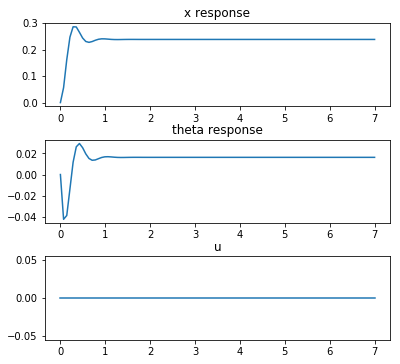

In [148]:
t_start = 0 # [s]
t_end = 7   # [s]
n = 100 

T = np.linspace(t_start, t_end, n)
u = np.full((n,), 0)
X0 = [0, 0, 0, -1]

t_sim, y_sim, x_sim = control.input_output_response(
    pendulum, T, u, X0, params=pend_params, return_x=True)

fig, axs = plt.subplots(3)
axs[0].plot(T, y_sim[0])
axs[0].set_title('x response')
axs[1].plot(T, y_sim[2])
axs[1].set_title('theta response')
axs[2].plot(T, u)
axs[2].set_title('u')
plt.subplots_adjust(left=0.1,
                    bottom=0.2, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)

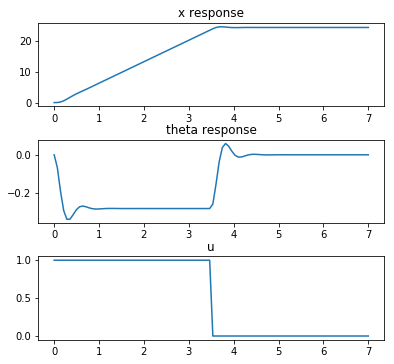

In [149]:
t_start = 0 # [s]
t_end = 7   # [s]
n = 100 

T = np.linspace(t_start, t_end, n)
u_1 = np.full((int(n/2),), 1)
u_2 = np.full((int(n/2),), 0)
u = np.hstack((u_1, u_2))
X0 = [0, 0, 0, 0]

t_sim, y_sim, x_sim = control.input_output_response(
    pendulum, T, u, X0, params=pend_params, return_x=True)

fig, axs = plt.subplots(3)
axs[0].plot(T, y_sim[0])
axs[0].set_title('x response')
axs[1].plot(T, y_sim[2])
axs[1].set_title('theta response')
axs[2].plot(T, u)
axs[2].set_title('u')
plt.subplots_adjust(left=0.1,
                    bottom=0.2, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)

## LQR controller design with control lib. python:

In [54]:
Q = [[1, 0, 0, 0],[0, 0.1, 0, 0],[0, 0, 5, 0],[0, 0, 0, 0.1]]             # state cost matrix
R = [[0.05]]                                                              # input cost matrix

K_lqr, S, E = control.lqr(sys, Q, R)

print(K_lqr)

[[-4.47213595 -5.06393848 31.65583773  5.91788676]]


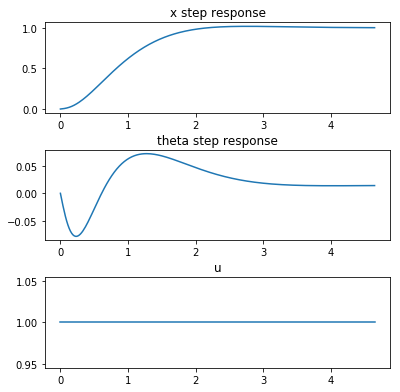

In [55]:
sys_lqr = control.StateSpace(A-B*K_lqr, -K_lqr.transpose(), C, D)

k_lqr = control.dcgain(sys_lqr)
kr = [1/k_lqr[0][0], 1, 1/k_lqr[1][0], 1]

sys_lqr *= kr                              # rescailing

response_lqr = control.step_response(sys_lqr)

fig, axs = plt.subplots(3)
axs[0].plot(response_lqr.time, response_lqr.outputs[0][0])
axs[0].set_title('x step response')
axs[1].plot(response_lqr.time, response_lqr.outputs[1][0])
axs[1].set_title('theta step response')
axs[2].plot(response_lqr.time, response_lqr.inputs[0][0])
axs[2].set_title('u')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)

## Nonlinear model of inverted pendulum with inputs (scipy.integrate.odeint)

### Mathematical equations for inverted pendulum:



1) $(I + m.l^2) \cdot \ddot{\theta} - m.g.l.\theta = m.l.\ddot{x}$

2) $(M + m) \cdot \ddot{x} + b.\dot{x} - m.l.\ddot{\theta} = F$

          _|  |_
          \    /
           \  /
            \/
                    
1) $\ddot{\theta} = \frac{m.l}{(I+m.l^2)} \cdot \ddot{x} + \frac{m.g.l}{I+m.l^2} \cdot \dot{\theta}$

2) $ \ddot{x} = \frac{-b}{(M+m)} \cdot \dot{x} + \frac{m.l}{M+m} \cdot \ddot{\theta} + F$

          _|  |_
          \    /
           \  /
            \/
            
  $q = (I+m.l^2) \cdot (M+m) - (m.l)^2$
  
1) $ \ddot{x} = \frac{-b.(I+ml^2)}{q} \cdot \dot{x} + \frac{g.(ml)^2}{q} \cdot \dot{\theta} + \frac{(M+m)(I+ml^2)}{q} \cdot F$ 



2) $\ddot{\theta} = \frac{-b.m.l}{q} \cdot \dot{x} + \frac{m.l.(M+m)}{q} \cdot F + \frac{m.g.l.(I+m.l^2)}{q} \cdot \dot{\theta}$


In [150]:
# Building custom non-linear model

t = np.arange(0, 20, 1e-3)


def F(x, t):
    
    return 1

def f(x, t):
    
    M = 0.5     # mass of the cart
    m = 0.2   # mass of the pendulum
    b = 0.1   # coefficient of the friction
    I = 0.006 # mass moment of inertia of the pendulum
    g = 9.81   # acceleration of gravity
    l = 0.3   # length to pendulum center of mass
    
    d_x = np.zeros((4,))
    
    q = (I + m*l**2)*(M + m) - (m*l**2)
    # dot_x
    d_x[0] = x[1]
    # ddot_x
    d_x[1] = ((-b*(I+m*l**2))/q)*x[1] + ((g*(m*l)**2)/q)*x[3] + (((M+m)*(I+m*l**2))/q)*F(x, t)
    # dot_theta
    d_x[2] = x[3]
    # ddot_theta
    d_x[3] = ((-b*m*l)/q)*x[1] + ((m*g*l*(I+m*l**2))/q)*x[3] + ((m*l*(M+m))/q)*F(x, t)
    
    return d_x



s = odeint(f, y0=[0, 0, 0, 0], t=t)


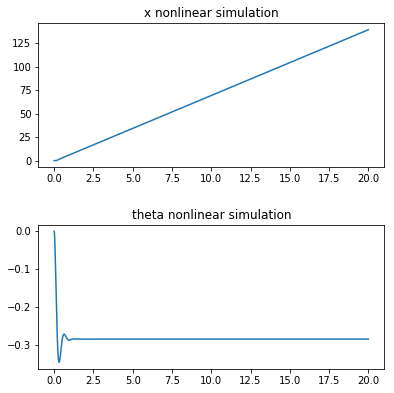

In [151]:
fig, axs = plt.subplots(2)
axs[0].plot(t, s[:, 0])
axs[0].set_title('x nonlinear simulation')
axs[1].plot(t, s[:, 2])
axs[1].set_title('theta nonlinear simulation')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)